In [59]:
import torch
import torch.nn as nn
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math
from torch.utils.data import DataLoader
import einops

Load CIFAR-10 dataset

In [60]:
transform = T.Compose([
    T.ToTensor(),  # converts to [0, 1]
    T.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])
dataset = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)
img, label = dataset[0]  # get a single image
x0 = img.unsqueeze(0)  # add batch dimension

In [61]:
batch_size = 64
dataset_loader = DataLoader(dataset, batch_size, shuffle=False)
imgs, lbls = next(iter(dataset_loader))

Get noise scheduler

In [62]:
import torch
from torch import nn
from typing import Tuple
class LinearNoiseScheduler(nn.Module):
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()

        self.timesteps = timesteps

        # Start and end are the beta values for the linear noise schedule that we linearly interpolate between (hence linear scheduler)
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas # Equation 1
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # Equation 2
    
    def to(self, device):
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_hat = self.alpha_hat.to(device)
        return self

    def forward(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward process: q(x_t | x_0)

        Returns the noisy image at time t and the noise added to the image.
        """
        x0_shape = x0.shape
        epsilon = torch.flatten(torch.randn_like(x0)) # Input: x_0 - it returns the same size/shape as the input tensor (i.e. image)

        # gather alpha_bars for each sample in the batch
        alpha_bar_t = torch.flatten(self.alpha_hat[t]).to(x0.device)
        first_term = torch.sqrt(alpha_bar_t) * torch.flatten(x0)
        second_term = torch.sqrt(1 - alpha_bar_t) * epsilon
        noisy_image = first_term + second_term # Equation 3

        noisy_image = noisy_image.reshape(x0_shape)
        epsilon = epsilon.reshape(x0_shape)

        return noisy_image, epsilon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3867354..2.6257613].


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


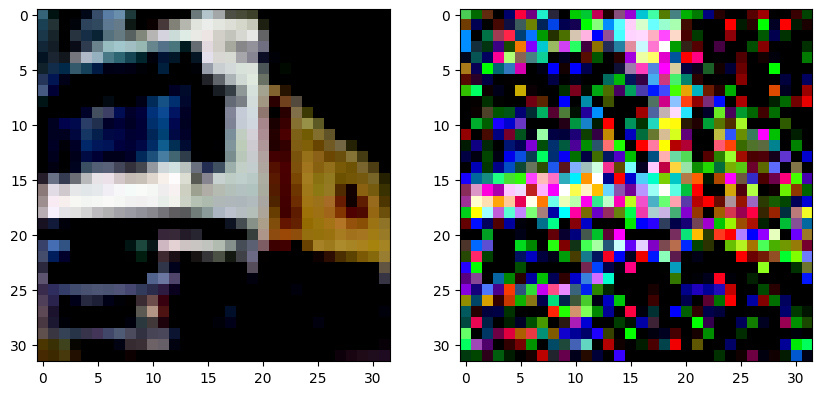

In [63]:
sched = LinearNoiseScheduler()

t = torch.randint(1, 301, imgs.shape)
noisy_imgs, noise = sched.forward(imgs, t)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

idx = 1
img = imgs[idx].detach().cpu()
noisy_img = noisy_imgs[idx]

print(img.shape)
print(noisy_img.shape)

img = einops.rearrange(img, "c h w -> h w c")
noisy_img = einops.rearrange(noisy_img, "c h w -> h w c")
axes[0].imshow(img)
axes[1].imshow(noisy_img)
plt.show()